# Agenda

- Run convergence examples through GPT-J and GPT-Neo.
- Time to converge and convergence plots?

In [1]:
import numpy as np
np.random.seed(20230126)

N_SEEDS = 40
num_samples = 100

SEEDS = np.unique(np.random.randint(0, 10**6, N_SEEDS))
print("Total #sequences:", N_SEEDS*num_samples)

# User definitions
model_name = "EleutherAI/gpt-neo-125M"

TOKENIZER_CLASS = None
MODEL_CLASS = None
MAX_LENGTH = None
MAX_TOKENS = 100

if "gpt-neo" in model_name:
    # reference: https://huggingface.co/docs/transformers/model_doc/gpt_neo
    from transformers import GPT2Tokenizer, GPTNeoForCausalLM
    TOKENIZER_CLASS, MODEL_CLASS, MAX_LENGTH = GPT2Tokenizer, GPTNeoForCausalLM, 256

elif "gpt2" in model_name:
    from transformers import GPT2Tokenizer, GPT2LMHeadModel
    TOKENIZER_CLASS, MODEL_CLASS, MAX_LENGTH = GPT2Tokenizer, GPT2LMHeadModel, 512
else:
    raise NotImplemented

# ==========================================================
# Load models
print("Importing classes for model", model_name, "with model length", MAX_LENGTH)
print(" ->", TOKENIZER_CLASS)
print(" ->", MODEL_CLASS)
tokenizer = TOKENIZER_CLASS.from_pretrained(model_name, model_max_length=MAX_LENGTH)
model = MODEL_CLASS.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

print("Vocabulary size:", tokenizer.vocab_size)

Total #sequences: 4000
Importing classes for model EleutherAI/gpt-neo-125M with model length 256
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257


In [2]:
import time


def time_it(f):
    """Function wrapper to compute execution time of function f"""
    
    def inner1(*args, **kwargs):
        start = time.time()
        results = f(*args, **kwargs)
        end = time.time()
        print(f"Total time taken in {f.__name__}: {round(end-start, 2)} (s) for {MODEL_CLASS}.")
        return results
    
    return inner1

## Naive Sampling

In [3]:
def get_naive_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    # Call Naive Sampling
    probabilities, samples = naive_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
   

    if debug:
        mean, std = probabilities.mean().item(), probabilities.std().item()
        print("Freq:", mean, "Std:", std)
        print("Produced samples")
        print("\n".join(tokenizer.batch_decode(samples)[::5]))

    return probabilities, samples

## Importance sampling

In [4]:
from utils import set_seed
from tqdm import tqdm
set_seed(42)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [6]:
def get_imp_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    probabilities, samples, _ = importance_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
    
    return probabilities, samples


def compute_mean_std(array, stepsize=5):
    means = []
    stds = []
    ids = []
    
    for i in range(stepsize, len(array), stepsize):
        mean = array[:i].mean().item()
        means.append(mean)
        
        std = array[:i].std().item() / np.sqrt(i)
        stds.append((mean-std, mean+std)) 
        ids.append(i)
    else:
        mean = array.mean().item()
        means.append(mean)
        std = array.std().item() / np.sqrt(i)
        stds.append((mean-std, mean+std))
        ids.append(len(array))
        
    return means, stds, ids


@time_it
def run_naive_sampling(input_str, avoid_terms, max_num_tokens):
    estimates = []
    for seed in SEEDS:
        naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed, max_num_tokens=max_num_tokens)
        estimates.append(naive_out)
        
    return estimates

@time_it
def run_importance_sampling(input_str, avoid_terms, max_num_tokens):
    estimates = []
    for seed in SEEDS:
        imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed, max_num_tokens=max_num_tokens)
        estimates.append(imp_samp_out)

    return estimates

Total time taken in run_naive_sampling: 394.11 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.
Total time taken in run_importance_sampling: 429.68 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.


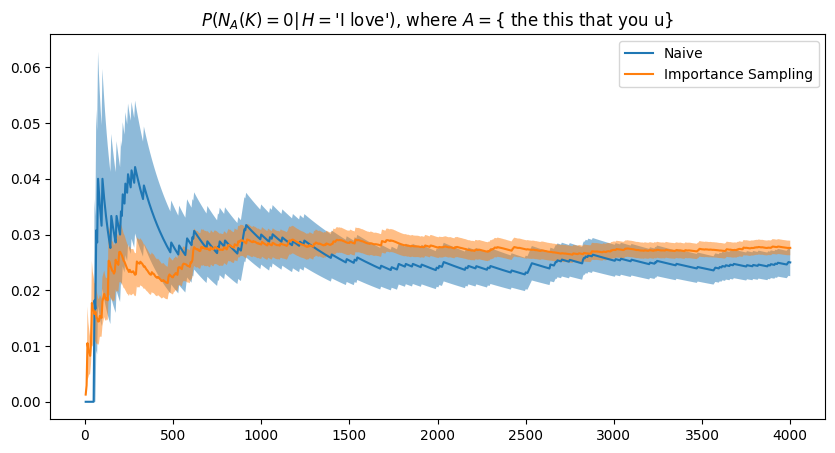

In [7]:
input_str, avoid_terms = "I love", " the this that you u"
naive_estimates, imp_estimates = [], []

naive_estimates = run_naive_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
imp_estimates   = run_importance_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")
plt.show()

Total time taken in run_naive_sampling: 400.13 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.
Total time taken in run_importance_sampling: 435.89 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.


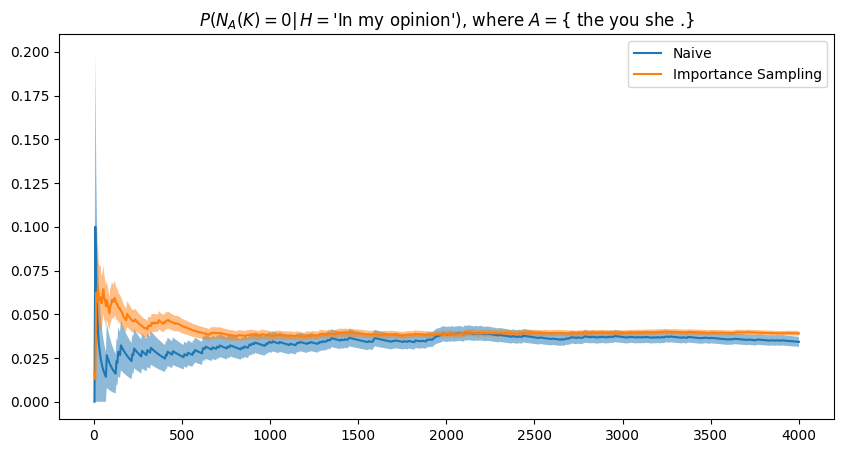

In [12]:
input_str, avoid_terms = "In my opinion", " the you she ."

naive_estimates = run_naive_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
imp_estimates   = run_importance_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)
plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")
plt.show()

Total time taken in run_naive_sampling: 408.03 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.
Total time taken in run_importance_sampling: 443.7 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.


Text(0.5, 1.0, "$P(N_A(K) = 0 |\\, H=$'Hi, my name is'$)$, where $A =${ and I}")

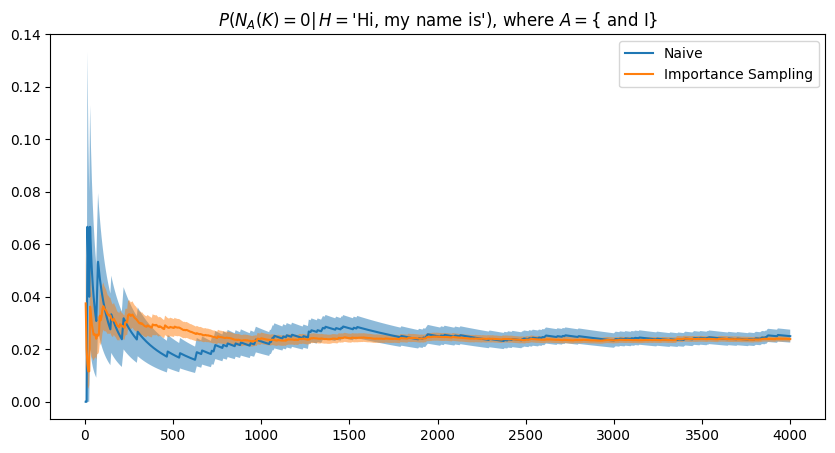

In [9]:
input_str, avoid_terms = "Hi, my name is", " and I"
naive_estimates, imp_estimates = [], []

naive_estimates = run_naive_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
imp_estimates   = run_importance_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")

Total time taken in run_naive_sampling: 399.22 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.
Total time taken in run_importance_sampling: 435.19 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.


Text(0.5, 1.0, "$P(N_A(K) = 0 |\\, H=$'Once upon a'$)$, where $A =${ time}")

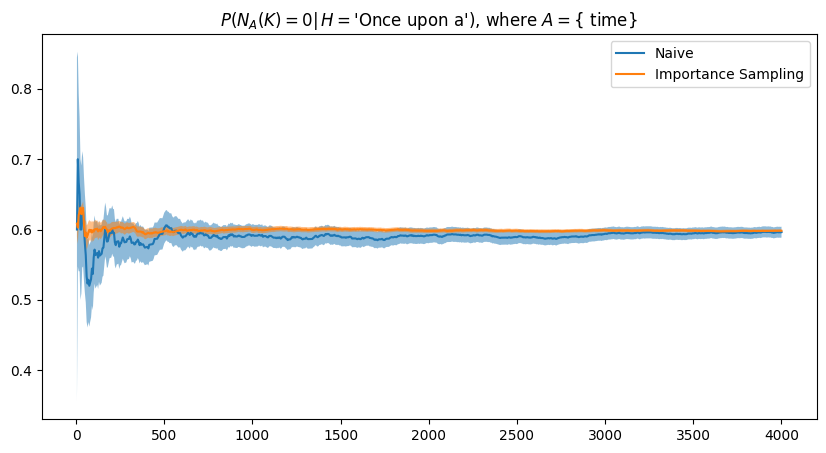

In [10]:
input_str, avoid_terms = "Once upon a", " time"
naive_estimates, imp_estimates = [], []

naive_estimates = run_naive_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
imp_estimates   = run_importance_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")

Total time taken in run_naive_sampling: 394.89 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.
Total time taken in run_importance_sampling: 430.44 (s) for <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>.


Text(0.5, 1.0, "$P(N_A(K) = 0 |\\, H=$'Where is'$)$, where $A =${ the he she next it ?}")

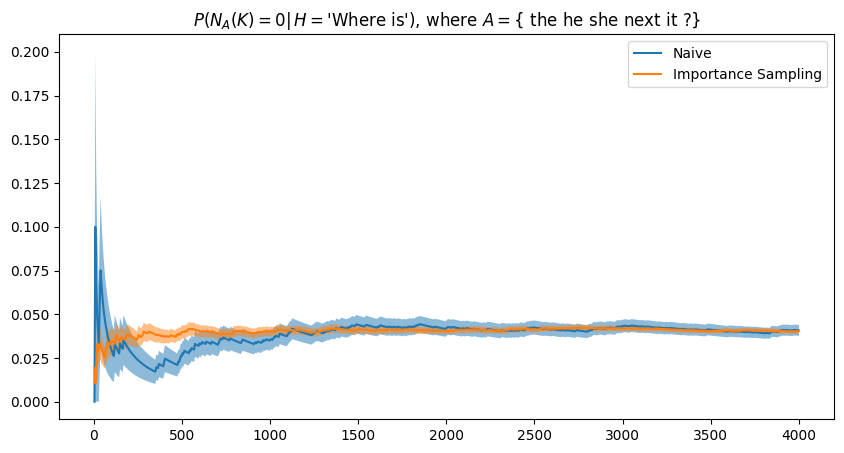

In [11]:
input_str, avoid_terms = "Where is", " the he she next it ?"
naive_estimates, imp_estimates = [], []


naive_estimates = run_naive_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
imp_estimates   = run_importance_sampling(input_str, avoid_terms, max_num_tokens=MAX_TOKENS)
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")